In [18]:
import sys
sys.path.append("..")
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import utils.interp_generators as igs
import utils.adv_ex_utils as aus
import utils.utils as utils
from utils.models import LeNet, DDNet
from utils.data_loaders import DataLoader

# makes default tensor a CUDA tensor so GPU can be used
device = torch.device(2 if torch.cuda.is_available() else 'cpu')
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_device(device)

In [19]:
net = DDNet(activation=torch.nn.functional.relu)

training_round = 2
# net_name = f'../trained_models/MNIST/training_round_{training_round}/ep{0}_wd{0}_jr{0}_{training_round}'
net_name = f'../trained_models/CIFAR-10/tests/jr{0}_ir1{.00001}_ir2{.000001}_scale{.1}'
net_name = f'../trained_models/CIFAR-10/training_round_1/ep0_wd0_jr0.01_1'

net.load_state_dict(torch.load(net_name))

# put model in evaluation mode. i.e. turn off dropout layers, etc.
net.eval()

# get data
dl = DataLoader(dataset='CIFAR-10', path='../data')
test_loader = dl.test_loader
train_loader = dl.train_loader

Files already downloaded and verified
Files already downloaded and verified


### Test for repeatability of gradient methods
On a unregularized network, this loop completes successfully without any nans being found in any of the interpretations generated.

In [10]:
for i in range(50):
    for samples, labels in test_loader:
        samples,labels = samples.to(device),labels.to(device)
        s1 = igs.simple_gradient(net, samples, labels, used=False)
        if torch.isnan(s1).any():
            print(f'found a nan in simple gradient map')
    for samples, labels in train_loader:
        samples,labels = samples.to(device),labels.to(device)
        s1 = igs.simple_gradient(net, samples, labels, used=False)
        if torch.isnan(s1).any():
            print(f'found a nan in simple gradient map')
    print(f'none found on epoch {i}')

none found on epoch 0
none found on epoch 1
none found on epoch 2
none found on epoch 3
none found on epoch 4
none found on epoch 5
none found on epoch 6
none found on epoch 7
none found on epoch 8
none found on epoch 9
none found on epoch 10
none found on epoch 11
none found on epoch 12
none found on epoch 13
none found on epoch 14
none found on epoch 15
none found on epoch 16
none found on epoch 17
none found on epoch 18
none found on epoch 19
none found on epoch 20
none found on epoch 21
none found on epoch 22
none found on epoch 23
none found on epoch 24
none found on epoch 25
none found on epoch 26
none found on epoch 27
none found on epoch 28
none found on epoch 29
none found on epoch 30
none found on epoch 31
none found on epoch 32
none found on epoch 33
none found on epoch 34
none found on epoch 35
none found on epoch 36
none found on epoch 37
none found on epoch 38
none found on epoch 39
none found on epoch 40
none found on epoch 41
none found on epoch 42
none found on epoch 4

In [16]:
for i in range(50):
    for samples, labels in test_loader:
        samples,labels = samples.to(device),labels.to(device)
        n,ix = utils.norm_diff_interp(net, samples, labels)
    for samples, labels in train_loader:
        samples,labels = samples.to(device),labels.to(device)
        n,ix = utils.norm_diff_interp(net, samples, labels)
    print(f'epoch {i}')

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22


KeyboardInterrupt: 

In [20]:
# get data
dl = DataLoader(dataset='CIFAR-10', tr_batch_size=1, te_batch_size=1, path='../data', augment=False)
test_loader = dl.test_loader
train_loader = dl.train_loader

Files already downloaded and verified
Files already downloaded and verified


### Check out CIFAR-10 examples

net(sample) = 2


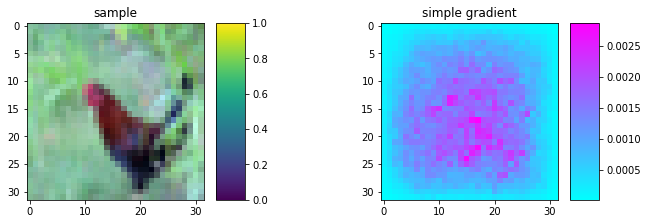

In [67]:
sample,label = next(iter(train_loader))
sample,label = sample.to(device),label.to(device)

# used = False needed if sample has not yet been converted to 
# a torch.Variable and made to require gradient
s1 = igs.smoothgrad(net, sample, label, j=15, scale=1., used=False)
s2 = igs.simple_gradient(net, sample, label, used=False, normalize=False)
sample = (sample-sample.min())/(sample.max()-sample.min())

fig = plt.figure(figsize=(10,3), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

print(f'net(sample) = {torch.argmax(net(sample))}')

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample')
plt.imshow(sample.squeeze().permute(1,2,0).cpu().numpy())
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('simple gradient')
plt.imshow(s1.squeeze().cpu().detach().numpy(), cmap='cool')
plt.colorbar()

plt.show()

#### CIFAR-10 class labels
<font size="1"> 
    airplane : 0,
    automobile : 1,
    bird : 2,
    cat : 3,
    deer : 4,
    dog : 5,
    frog : 6,
    horse : 7,
    ship : 8,
    truck : 9
</font>

### Make sure that parallelized version of simple gradients is working correctly

They did perform the same way, so the unparallelized version was removed.

sample1,label1 = next(iter(train_loader))
sample2,label2 = next(iter(train_loader))
samples,labels = torch.cat([sample1,sample2],dim=0),torch.cat([label1,label2],dim=0)
samples,labels = samples.to(device),labels.to(device)

# used = False needed if sample has not yet been converted to 
# a torch.Variable and made to require gradient
s = igs.simple_gradients(net, samples, labels, used=False)
s1 = igs.simple_gradient(net, samples[1].unsqueeze(0), labels[1].unsqueeze(0), used=False)

print(s.shape)

fig = plt.figure(figsize=(7,7), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

print(f'net(sample1, sample2) = {torch.argmax(net(samples), dim=1)}')

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample1')
plt.imshow(sample1.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('simple gradient for sample1')
plt.imshow(s[0].cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax3 = fig.add_subplot(spec[1,0])
ax3.title.set_text('sample2')
plt.imshow(sample2.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax4 = fig.add_subplot(spec[1,1])
ax4.title.set_text('simple gradient for sample2')
plt.imshow(s[1].cpu().detach().numpy(), cmap='binary')
plt.colorbar()

ax5 = fig.add_subplot(spec[2,1])
ax5.title.set_text('simple gradient for sample2')
plt.imshow(s1.cpu().detach().numpy(), cmap='binary')
plt.colorbar()

plt.show()

### Inspect effect of randomly perturbing a sample

max value: 2.821486711502075, min value: -0.4242129623889923
max value: 2.821500062942505, min value: -0.42419999837875366
net(sample1) = 2, net(sample2) = 2


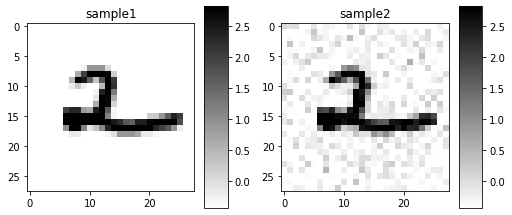

In [11]:
sample1,label1 = next(iter(train_loader))
sample1,label1 = sample1.to(device),label1.to(device)
sample2 = aus.perturb_randomly(sample1, scale=.3)

print(f'max value: {sample1.max().item()}, min value: {sample1.min().item()}')
print(f'max value: {sample2.max().item()}, min value: {sample2.min().item()}')
print(f'net(sample1) = {torch.argmax(net(sample1))}, net(sample2) = {torch.argmax(net(sample2))}')

fig = plt.figure(figsize=(7,3), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0,0])
ax1.title.set_text('sample1')
plt.imshow(sample1.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

ax2 = fig.add_subplot(spec[0,1])
ax2.title.set_text('sample2')
plt.imshow(sample2.squeeze().cpu().numpy(), cmap='binary')
plt.colorbar()

plt.show()